# Diffusion Models Final Project

## Installing the dependencies

This notebook leverages the [🤗 Datasets](https://huggingface.co/docs/datasets/index) library to load and preprocess image datasets and the [🤗 Accelerate](https://huggingface.co/docs/accelerate/index) library to simplify training on any number of GPUs, with features like automatic gradient accumulation and tensorboard logging. Let's install them here:

In [2]:
%%capture
!pip install -U diffusers[training]

In [3]:
%%capture
!pip install datasets

To be able to share your model with the community, there are a few more steps to follow.|

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your **write** token:

In [2]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 50
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-our-faces'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our image dataset.

In this case, the [Butterflies dataset](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) is hosted remotely, but you can load a local [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) as shown in the commets below.

In [10]:
from google.colab import files
import zipfile
import os
import shutil

# Create dataset directory if it doesn't exist
os.makedirs("dataset", exist_ok=True)
print("✅ Created or verified 'dataset/' directory")

# Upload ZIP file manually (this part is still manual as it requires user interaction)
uploaded = files.upload()

# Extract and organize files
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        # First extract everything to dataset folder
        zip_ref.extractall("dataset")
        print(f"✅ Extracted {filename} to 'dataset/'")

        # Check if "Merged Data Set" folder exists and move its contents up
        source_folder = os.path.join("dataset", "Merged Data Set")
        if os.path.exists(source_folder) and os.path.isdir(source_folder):
            # Move all files from the subfolder to the dataset root
            for sub_file in os.listdir(source_folder):
                src_path = os.path.join(source_folder, sub_file)
                dst_path = os.path.join("dataset", sub_file)
                shutil.move(src_path, dst_path)

            # Remove the now-empty subfolder
            try:
                os.rmdir(source_folder)
                print(f"✅ Moved files from 'Merged Data Set' to dataset root and removed subfolder")
            except OSError:
                print("⚠️ Could not remove 'Merged Data Set' folder (it may not be empty)")

# Check extracted files
print("📂 Files in dataset:", os.listdir("dataset"))

✅ Created or verified 'dataset/' directory


📂 Files in dataset: ['__MACOSX', 'video_frames']


In [11]:
from datasets import load_dataset

# ✅ Load images from the "dataset/" folder (matching example format)
dataset = load_dataset("imagefolder", data_dir="dataset")

print(dataset)  # Check if it's loaded correctly


# Feel free to try other datasets from https://hf.co/huggan/ too!
# Here's is a dataset of flower photos:
# config.dataset_name = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset_name, split="train")

# Or just load images from a local folder!
# config.dataset_name = "imagefolder"
# dataset = load_dataset(config.dataset_name, data_dir="path/to/folder")

Resolving data files:   0%|          | 0/1338 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 1338
    })
})


The dataset contains several extra `features` (columns), but the one that we're interested in is `image`:

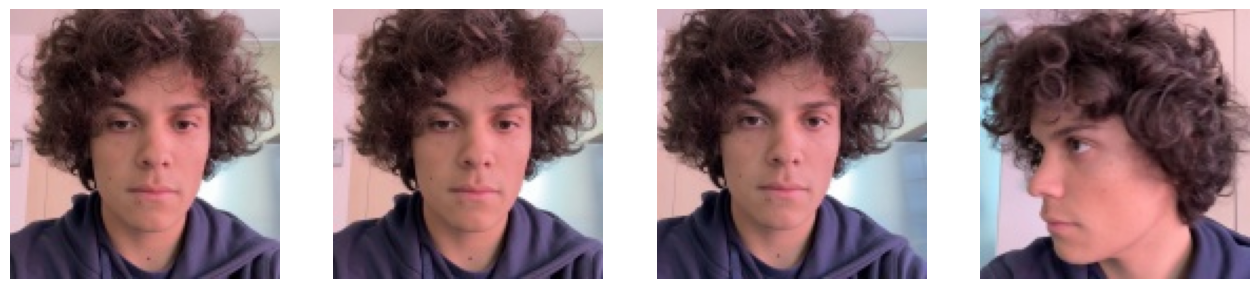

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):  # Access images from the train set
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()


Since the [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) feature loads the images with PIL, we can easily look at a few examples:

The images in the dataset are all different, so we need to preprocess them first:
* `Resize` makes the images conform to a square resolution of `config.image_size`
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` is important to rescale the pixel values into a `[-1, 1]` range (which our model will expect).

In [13]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

🤗 Datasets offer a handy `set_transform()` method to apply the image transformations on the fly during training:

In [14]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

Let's see what they look like now

In [15]:
print(dataset["train"][0])


{'images': tensor([[[ 0.6471,  0.6471,  0.6471,  ...,  0.6471,  0.6392,  0.6314],
         [ 0.6471,  0.6471,  0.6471,  ...,  0.6471,  0.6392,  0.6314],
         [ 0.6392,  0.6392,  0.6392,  ...,  0.6471,  0.6314,  0.6314],
         ...,
         [-0.0824, -0.0980, -0.4275,  ..., -0.6941, -0.7020, -0.6392],
         [-0.1765, -0.0902, -0.4275,  ..., -0.7176, -0.6941, -0.6235],
         [-0.2549, -0.0902, -0.4118,  ..., -0.7098, -0.6784, -0.6235]],

        [[ 0.5686,  0.5686,  0.5686,  ...,  0.3569,  0.3647,  0.3569],
         [ 0.5686,  0.5686,  0.5686,  ...,  0.3569,  0.3647,  0.3569],
         [ 0.5608,  0.5608,  0.5608,  ...,  0.3569,  0.3569,  0.3569],
         ...,
         [-0.1765, -0.1922, -0.5137,  ..., -0.7569, -0.7176, -0.6549],
         [-0.2549, -0.1686, -0.4980,  ..., -0.7804, -0.7098, -0.6392],
         [-0.3333, -0.1686, -0.4824,  ..., -0.7725, -0.6941, -0.6392]],

        [[ 0.6314,  0.6314,  0.6314,  ...,  0.4118,  0.3961,  0.3882],
         [ 0.6314,  0.6314,  0.631

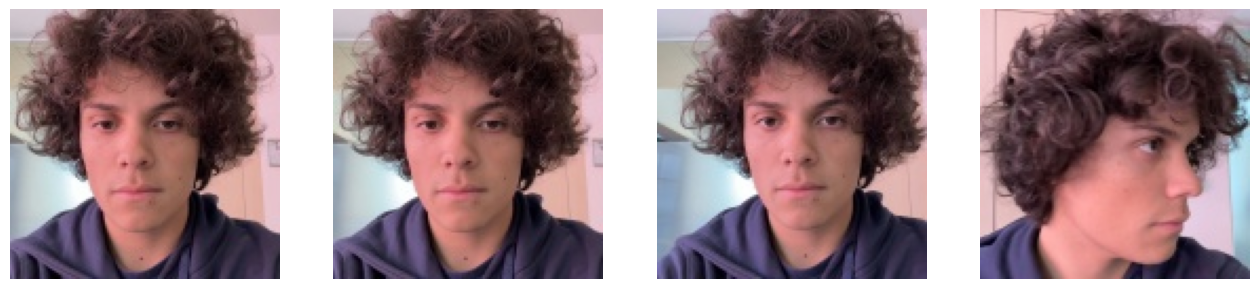

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)  # Convert to displayable format
    axs[i].set_axis_off()
fig.show()


Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [17]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):


In [18]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Let's get a sample image from our dataset and pass it into our model. We just need to add a batch dimension:

In [19]:
sample_image = dataset["train"][0]["images"].unsqueeze(0)  # ✅ Correct for your dataset
print("Input shape:", sample_image.shape)  # Should print (1, 3, 128, 128)


Input shape: torch.Size([1, 3, 128, 128])


And let's check the output is a tensor of the same exact shape:

In [20]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


Great!

Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

## Defining the noise scheduler

Depending on the diffusion algorithm you want to use, the way images are noised is slightly different. That's why 🤗 Diffusers contains different scheduler classes which each define the algorithm-specific diffusion steps. Here we are going to use the `DDPMScheduler` which corresponds to the training denoising and training algorithm proposed in [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [21]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Let's see how this noise scheduler works: it takes a batch of images from the trainng set (here we will reuse the batch of one image `sample_image` form before), a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image):

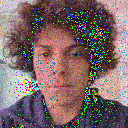

In [22]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`, so the loss at this step would be:

In [23]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [25]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk.

In [26]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

With this in end, we can group all together and write our training function. This just wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training.

In [27]:
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder

from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

    # Save original batch size before preparation
    original_batch_size = config.train_batch_size  # Use this if batch size is in config

    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    # Track losses for plotting
    epoch_losses = []

    # Print training configuration
    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {original_batch_size}")  # Use the saved batch size
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Gradient accumulation steps: {config.gradient_accumulation_steps}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Device: {accelerator.device}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # Now you train the model
    for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        # Track metrics for this epoch
        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Update metrics
            epoch_loss += loss.detach().item()

            # Update progress bar
            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch logging
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")

            # Plot loss curve periodically
            if (epoch + 1) % 5 == 0 or epoch == config.num_epochs - 1:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Saving model for epoch {epoch}...")
                # Always save the model first
                pipeline.save_pretrained(config.output_dir)

                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                print(f" Model saved successfully!")

## Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [28]:
from torch.utils.data import DataLoader

# Ensure the "train" split is correctly accessed
train_dataloader = DataLoader(
    dataset["train"],  # Access the 'train' split
    batch_size=config.train_batch_size,  # Set batch size
    shuffle=True
)

print(dataset.keys())  # Check if 'train' exists as a key



dict_keys(['train'])


In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  Starting training with the following configuration:
   - Number of epochs: 50
   - Batch size: 16
   - Mixed precision: fp16
   - Gradient accumulation steps: 1
   - Output directory: ddpm-our-faces
   - Device: cuda
   - Number of training samples: 1338


  0%|          | 0/84 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)



 Epoch: 0, Step: 0/84, Loss: 1.1175, Avg Loss: 1.1175, LR: 0.000002
   - Noise prediction stats: Mean: 0.0055, Std: 0.3021
   - Target noise stats: Mean: 0.0009, Std: 0.9996

 Epoch 0 completed. Average loss: 0.2872


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 1, Step: 0/84, Loss: 0.0796, Avg Loss: 0.0796, LR: 0.000000
   - Noise prediction stats: Mean: -0.0133, Std: 0.9567
   - Target noise stats: Mean: 0.0015, Std: 1.0000

 Epoch 1 completed. Average loss: 0.0487


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 2, Step: 0/84, Loss: 0.0933, Avg Loss: 0.0933, LR: 0.000000
   - Noise prediction stats: Mean: -0.0007, Std: 0.9501
   - Target noise stats: Mean: -0.0012, Std: 0.9995

 Epoch 2 completed. Average loss: 0.0373


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 3, Step: 0/84, Loss: 0.0192, Avg Loss: 0.0192, LR: 0.000000
   - Noise prediction stats: Mean: 0.0083, Std: 0.9961
   - Target noise stats: Mean: -0.0022, Std: 1.0013

 Epoch 3 completed. Average loss: 0.0376


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 4, Step: 0/84, Loss: 0.0299, Avg Loss: 0.0299, LR: 0.000000
   - Noise prediction stats: Mean: 0.0067, Std: 0.9761
   - Target noise stats: Mean: 0.0004, Std: 1.0003

 Epoch 4 completed. Average loss: 0.0278
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_4.png


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 5, Step: 0/84, Loss: 0.0117, Avg Loss: 0.0117, LR: 0.000000
   - Noise prediction stats: Mean: 0.0142, Std: 0.9880
   - Target noise stats: Mean: 0.0008, Std: 1.0003

 Epoch 5 completed. Average loss: 0.0287


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 6, Step: 0/84, Loss: 0.0139, Avg Loss: 0.0139, LR: 0.000000
   - Noise prediction stats: Mean: 0.0127, Std: 0.9979
   - Target noise stats: Mean: -0.0024, Std: 1.0017

 Epoch 6 completed. Average loss: 0.0275


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 7, Step: 0/84, Loss: 0.0199, Avg Loss: 0.0199, LR: 0.000000
   - Noise prediction stats: Mean: -0.0158, Std: 0.9842
   - Target noise stats: Mean: -0.0004, Std: 1.0004

 Epoch 7 completed. Average loss: 0.0244


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 8, Step: 0/84, Loss: 0.0151, Avg Loss: 0.0151, LR: 0.000000
   - Noise prediction stats: Mean: -0.0013, Std: 0.9911
   - Target noise stats: Mean: 0.0004, Std: 0.9999

 Epoch 8 completed. Average loss: 0.0194


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 9, Step: 0/84, Loss: 0.0326, Avg Loss: 0.0326, LR: 0.000000
   - Noise prediction stats: Mean: 0.0016, Std: 0.9863
   - Target noise stats: Mean: -0.0010, Std: 1.0002

 Epoch 9 completed. Average loss: 0.0258
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_9.png
 Generating sample images for epoch 9...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 10, Step: 0/84, Loss: 0.0152, Avg Loss: 0.0152, LR: 0.000000
   - Noise prediction stats: Mean: 0.0001, Std: 0.9863
   - Target noise stats: Mean: 0.0012, Std: 0.9998

 Epoch 10 completed. Average loss: 0.0197


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 11, Step: 0/84, Loss: 0.0146, Avg Loss: 0.0146, LR: 0.000000
   - Noise prediction stats: Mean: 0.0003, Std: 0.9896
   - Target noise stats: Mean: -0.0011, Std: 1.0007

 Epoch 11 completed. Average loss: 0.0199


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 12, Step: 0/84, Loss: 0.0698, Avg Loss: 0.0698, LR: 0.000000
   - Noise prediction stats: Mean: 0.0152, Std: 0.9533
   - Target noise stats: Mean: -0.0005, Std: 1.0010

 Epoch 12 completed. Average loss: 0.0172


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 13, Step: 0/84, Loss: 0.0391, Avg Loss: 0.0391, LR: 0.000000
   - Noise prediction stats: Mean: 0.0021, Std: 0.9757
   - Target noise stats: Mean: 0.0024, Std: 1.0002

 Epoch 13 completed. Average loss: 0.0203


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 14, Step: 0/84, Loss: 0.0150, Avg Loss: 0.0150, LR: 0.000000
   - Noise prediction stats: Mean: -0.0063, Std: 0.9968
   - Target noise stats: Mean: 0.0012, Std: 0.9990

 Epoch 14 completed. Average loss: 0.0183
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_14.png


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 15, Step: 0/84, Loss: 0.0310, Avg Loss: 0.0310, LR: 0.000000
   - Noise prediction stats: Mean: -0.0008, Std: 0.9788
   - Target noise stats: Mean: 0.0014, Std: 0.9981

 Epoch 15 completed. Average loss: 0.0180


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 16, Step: 0/84, Loss: 0.0065, Avg Loss: 0.0065, LR: 0.000000
   - Noise prediction stats: Mean: 0.0054, Std: 1.0133
   - Target noise stats: Mean: 0.0016, Std: 1.0006

 Epoch 16 completed. Average loss: 0.0189


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 17, Step: 0/84, Loss: 0.0171, Avg Loss: 0.0171, LR: 0.000000
   - Noise prediction stats: Mean: -0.0039, Std: 0.9847
   - Target noise stats: Mean: 0.0006, Std: 1.0024

 Epoch 17 completed. Average loss: 0.0145


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 18, Step: 0/84, Loss: 0.0173, Avg Loss: 0.0173, LR: 0.000000
   - Noise prediction stats: Mean: 0.0092, Std: 0.9989
   - Target noise stats: Mean: 0.0000, Std: 1.0000

 Epoch 18 completed. Average loss: 0.0148


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 19, Step: 0/84, Loss: 0.0102, Avg Loss: 0.0102, LR: 0.000000
   - Noise prediction stats: Mean: -0.0063, Std: 0.9831
   - Target noise stats: Mean: -0.0015, Std: 1.0005

 Epoch 19 completed. Average loss: 0.0163
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_19.png
 Generating sample images for epoch 19...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 20, Step: 0/84, Loss: 0.0112, Avg Loss: 0.0112, LR: 0.000000
   - Noise prediction stats: Mean: -0.0021, Std: 0.9873
   - Target noise stats: Mean: 0.0012, Std: 0.9998

 Epoch 20 completed. Average loss: 0.0156


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 21, Step: 0/84, Loss: 0.0114, Avg Loss: 0.0114, LR: 0.000000
   - Noise prediction stats: Mean: -0.0036, Std: 0.9941
   - Target noise stats: Mean: -0.0011, Std: 1.0007

 Epoch 21 completed. Average loss: 0.0164


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 22, Step: 0/84, Loss: 0.0624, Avg Loss: 0.0624, LR: 0.000000
   - Noise prediction stats: Mean: -0.0023, Std: 0.9732
   - Target noise stats: Mean: -0.0005, Std: 1.0010

 Epoch 22 completed. Average loss: 0.0143


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 23, Step: 0/84, Loss: 0.0344, Avg Loss: 0.0344, LR: 0.000000
   - Noise prediction stats: Mean: 0.0087, Std: 0.9758
   - Target noise stats: Mean: 0.0024, Std: 1.0002

 Epoch 23 completed. Average loss: 0.0173


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 24, Step: 0/84, Loss: 0.0124, Avg Loss: 0.0124, LR: 0.000000
   - Noise prediction stats: Mean: -0.0007, Std: 0.9975
   - Target noise stats: Mean: 0.0012, Std: 0.9990

 Epoch 24 completed. Average loss: 0.0156
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_24.png


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 25, Step: 0/84, Loss: 0.0269, Avg Loss: 0.0269, LR: 0.000000
   - Noise prediction stats: Mean: 0.0005, Std: 0.9871
   - Target noise stats: Mean: 0.0014, Std: 0.9981

 Epoch 25 completed. Average loss: 0.0153


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 26, Step: 0/84, Loss: 0.0052, Avg Loss: 0.0052, LR: 0.000000
   - Noise prediction stats: Mean: -0.0006, Std: 1.0082
   - Target noise stats: Mean: 0.0016, Std: 1.0006

 Epoch 26 completed. Average loss: 0.0163


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 27, Step: 0/84, Loss: 0.0148, Avg Loss: 0.0148, LR: 0.000000
   - Noise prediction stats: Mean: -0.0006, Std: 0.9850
   - Target noise stats: Mean: 0.0006, Std: 1.0024

 Epoch 27 completed. Average loss: 0.0124


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 28, Step: 0/84, Loss: 0.0147, Avg Loss: 0.0147, LR: 0.000000
   - Noise prediction stats: Mean: 0.0063, Std: 0.9926
   - Target noise stats: Mean: 0.0000, Std: 1.0000

 Epoch 28 completed. Average loss: 0.0129


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 29, Step: 0/84, Loss: 0.0082, Avg Loss: 0.0082, LR: 0.000000
   - Noise prediction stats: Mean: -0.0047, Std: 0.9919
   - Target noise stats: Mean: -0.0015, Std: 1.0005

 Epoch 29 completed. Average loss: 0.0143
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_29.png
 Generating sample images for epoch 29...


  0%|          | 0/1000 [00:00<?, ?it/s]

 Saving model for epoch 29...


events.out.tfevents.1740688944.cb08ae130fff.1436.0:   0%|          | 0.00/438k [00:00<?, ?B/s]

0019.png:   0%|          | 0.00/492k [00:00<?, ?B/s]

0009.png:   0%|          | 0.00/519k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

0029.png:   0%|          | 0.00/499k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

 Model saved successfully!


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 30, Step: 0/84, Loss: 0.0095, Avg Loss: 0.0095, LR: 0.000000
   - Noise prediction stats: Mean: -0.0032, Std: 0.9913
   - Target noise stats: Mean: 0.0012, Std: 0.9998

 Epoch 30 completed. Average loss: 0.0138


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 31, Step: 0/84, Loss: 0.0098, Avg Loss: 0.0098, LR: 0.000000
   - Noise prediction stats: Mean: -0.0023, Std: 0.9938
   - Target noise stats: Mean: -0.0011, Std: 1.0007

 Epoch 31 completed. Average loss: 0.0145


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 32, Step: 0/84, Loss: 0.0569, Avg Loss: 0.0569, LR: 0.000000
   - Noise prediction stats: Mean: -0.0098, Std: 0.9833
   - Target noise stats: Mean: -0.0005, Std: 1.0010

 Epoch 32 completed. Average loss: 0.0127


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 33, Step: 0/84, Loss: 0.0323, Avg Loss: 0.0323, LR: 0.000000
   - Noise prediction stats: Mean: 0.0074, Std: 0.9742
   - Target noise stats: Mean: 0.0024, Std: 1.0002

 Epoch 33 completed. Average loss: 0.0156


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 34, Step: 0/84, Loss: 0.0111, Avg Loss: 0.0111, LR: 0.000000
   - Noise prediction stats: Mean: -0.0001, Std: 0.9968
   - Target noise stats: Mean: 0.0012, Std: 0.9990

 Epoch 34 completed. Average loss: 0.0141
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_34.png


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 35, Step: 0/84, Loss: 0.0249, Avg Loss: 0.0249, LR: 0.000000
   - Noise prediction stats: Mean: 0.0010, Std: 0.9891
   - Target noise stats: Mean: 0.0014, Std: 0.9981

 Epoch 35 completed. Average loss: 0.0138


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 36, Step: 0/84, Loss: 0.0044, Avg Loss: 0.0044, LR: 0.000000
   - Noise prediction stats: Mean: -0.0001, Std: 0.9986
   - Target noise stats: Mean: 0.0016, Std: 1.0006

 Epoch 36 completed. Average loss: 0.0149


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 37, Step: 0/84, Loss: 0.0133, Avg Loss: 0.0133, LR: 0.000000
   - Noise prediction stats: Mean: -0.0026, Std: 0.9956
   - Target noise stats: Mean: 0.0006, Std: 1.0024

 Epoch 37 completed. Average loss: 0.0112


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 38, Step: 0/84, Loss: 0.0132, Avg Loss: 0.0132, LR: 0.000000
   - Noise prediction stats: Mean: 0.0025, Std: 0.9892
   - Target noise stats: Mean: 0.0000, Std: 1.0000

 Epoch 38 completed. Average loss: 0.0115


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 39, Step: 0/84, Loss: 0.0070, Avg Loss: 0.0070, LR: 0.000000
   - Noise prediction stats: Mean: -0.0007, Std: 0.9976
   - Target noise stats: Mean: -0.0015, Std: 1.0005

 Epoch 39 completed. Average loss: 0.0130
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_39.png
 Generating sample images for epoch 39...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 40, Step: 0/84, Loss: 0.0084, Avg Loss: 0.0084, LR: 0.000000
   - Noise prediction stats: Mean: -0.0066, Std: 0.9961
   - Target noise stats: Mean: 0.0012, Std: 0.9998

 Epoch 40 completed. Average loss: 0.0126


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 41, Step: 0/84, Loss: 0.0088, Avg Loss: 0.0088, LR: 0.000000
   - Noise prediction stats: Mean: -0.0001, Std: 0.9921
   - Target noise stats: Mean: -0.0011, Std: 1.0007

 Epoch 41 completed. Average loss: 0.0132


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 42, Step: 0/84, Loss: 0.0537, Avg Loss: 0.0537, LR: 0.000000
   - Noise prediction stats: Mean: -0.0034, Std: 0.9888
   - Target noise stats: Mean: -0.0005, Std: 1.0010

 Epoch 42 completed. Average loss: 0.0116


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 43, Step: 0/84, Loss: 0.0302, Avg Loss: 0.0302, LR: 0.000000
   - Noise prediction stats: Mean: 0.0054, Std: 0.9786
   - Target noise stats: Mean: 0.0024, Std: 1.0002

 Epoch 43 completed. Average loss: 0.0146


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 44, Step: 0/84, Loss: 0.0104, Avg Loss: 0.0104, LR: 0.000000
   - Noise prediction stats: Mean: 0.0024, Std: 0.9812
   - Target noise stats: Mean: 0.0012, Std: 0.9990

 Epoch 44 completed. Average loss: 0.0132
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_44.png


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 45, Step: 0/84, Loss: 0.0230, Avg Loss: 0.0230, LR: 0.000000
   - Noise prediction stats: Mean: 0.0002, Std: 0.9880
   - Target noise stats: Mean: 0.0014, Std: 0.9981

 Epoch 45 completed. Average loss: 0.0127


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 46, Step: 0/84, Loss: 0.0039, Avg Loss: 0.0039, LR: 0.000000
   - Noise prediction stats: Mean: -0.0001, Std: 1.0021
   - Target noise stats: Mean: 0.0016, Std: 1.0006

 Epoch 46 completed. Average loss: 0.0138


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 47, Step: 0/84, Loss: 0.0122, Avg Loss: 0.0122, LR: 0.000000
   - Noise prediction stats: Mean: -0.0003, Std: 0.9925
   - Target noise stats: Mean: 0.0006, Std: 1.0024

 Epoch 47 completed. Average loss: 0.0103


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 48, Step: 0/84, Loss: 0.0121, Avg Loss: 0.0121, LR: 0.000000
   - Noise prediction stats: Mean: 0.0004, Std: 0.9893
   - Target noise stats: Mean: 0.0000, Std: 1.0000

 Epoch 48 completed. Average loss: 0.0106


  0%|          | 0/84 [00:00<?, ?it/s]


 Epoch: 49, Step: 0/84, Loss: 0.0063, Avg Loss: 0.0063, LR: 0.000000
   - Noise prediction stats: Mean: -0.0028, Std: 0.9976
   - Target noise stats: Mean: -0.0015, Std: 1.0005

 Epoch 49 completed. Average loss: 0.0121
 Loss plot saved to ddpm-our-faces/loss_plot_epoch_49.png
 Generating sample images for epoch 49...


  0%|          | 0/1000 [00:00<?, ?it/s]

Let's have a look at the final image grid produced by the trained diffusion model:

In [1]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

NameError: name 'config' is not defined

Not bad! There's room for improvement of course, so feel free to play with the hyperparameters, model definition and image augmentations 🤗

If you've chosen to upload the model to the Hugging Face Hub, its repository should now look like so:
https://huggingface.co/anton-l/ddpm-butterflies-128/tree/main

If you want to dive deeper into the code, we also have more advanced training scripts with features like Exponential Moving Average of model weights here:

https://github.com/huggingface/diffusers/tree/main/examples

If we want to run the code by selecting the model from huggging face, run the following

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Load model
pipeline = DDPMPipeline.from_pretrained("otausendschoen/ddpm-our-faces")

# Move to GPU and use half precision
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = pipeline.to(device)
if device == "cuda":
    pipeline = pipeline.to(torch.float16)  # Only on CUDA

# Use faster scheduler with fewer steps
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.scheduler.set_timesteps(20)  # Dramatically fewer steps

# Generate images
images = pipeline(
    batch_size=4,
    generator=torch.Generator(device=device).manual_seed(42)
).images

# Save the images
for i, image in enumerate(images):
    image.save(f"fast_generated_{i}.png")